In [3]:
import numpy as np

import cma
import sys
import math

from DDPG.test.helpers.draw import draw_policy, run
from DDPG.core.helpers.Chrono import Chrono

import matplotlib.pyplot as plt

from simple_keras_net import Keras_NN

import gym

#env = gym.make('Pendulum-v0')
layer_nb = 4
sigma = 0.5

numpoids1 = 2
numpoids2 = 4
scale = 5

class CMA():

    def __init__(self):
        '''
	Input:
        '''
        self.env = gym.make('MountainCarContinuous-v0')
        self.env.reset(False)
        self.controller = Keras_NN(2,1)
        self.controller.load_theta('cma_agents/best_agent.theta959')
        self.nb_episodes = 0
        self.options = cma.CMAOptions()
        self.options['maxiter']=200
        self.options['popsize']=50
        self.options['CMA_diagonal']=True
        self.options['verb_log']=50
        self.options['verb_disp']=1
        self.best_perf = -10000.0
        self.controller.set_param(layer_nb, numpoids1, 0.1)
        self.controller.set_param(layer_nb, numpoids2, 0.85)
        self.green_dots = []
        self.white_dots = []
        self.black_dots = []

        self.xmin = 10000
        self.ymin = 10000
        self.xmax = -10000
        self.ymax = -10000

    def final_draw(self):
        plt.close()
        self.draw_cost_landscape(self.controller,numpoids1,numpoids2,scale)
        for i in range(len(self.black_dots)):
            plt.scatter(self.black_dots[i][0], self.black_dots[i][1], c="black")
        for i in range(len(self.green_dots)):
            plt.scatter(self.green_dots[i][0], self.green_dots[i][1], c="green")
        for i in range(len(self.white_dots)):
            plt.scatter(self.white_dots[i][0], self.white_dots[i][1], c="white")
        plt.show(block=False)

        
    def draw_cost_landscape(self,agent,numpoids1,numpoids2,scale):
        x_range = self.xmax -self.xmin
        y_range = self.ymax -self.ymin
        scale = max(1, scale * max(x_range,y_range)/2)
        nb_valuesx = int(x_range*100/scale)
        nb_valuesy = int(y_range*100/scale)
        
        img = np.zeros((nb_valuesx, nb_valuesy))
        poids1 = self.xmin
        save1 = agent.get_param(layer_nb,numpoids1)
        save2 = agent.get_param(layer_nb,numpoids2)
        
        for i in range(nb_valuesx):
            poids2 = self.ymin
            poids1 += 0.01*scale
            for j in range(nb_valuesy):
                poids2 += 0.01*scale
                agent.set_param(layer_nb,numpoids1,poids1)
                agent.set_param(layer_nb,numpoids2,poids2)
                global_reward = run(agent,self.env,False,False)
                img[i][j] = global_reward

        agent.set_param(layer_nb,numpoids1,save1)
        agent.set_param(layer_nb,numpoids2,save2)
        plt.imshow(img, extent=(self.xmin,self.xmax,self.ymin,self.ymax))

    def run_episode(self,x):
        w1 = x[0]
        w2 = x[1]
        self.controller.set_param(layer_nb, numpoids1, w1)
        self.controller.set_param(layer_nb, numpoids2, w2)
        if w1>self.xmax: self.xmax = w1
        if w1<self.xmin: self.xmin = w1
        if w2>self.ymax: self.ymax = w2
        if w2<self.ymin: self.ymin = w2
        self.nb_episodes += 1
        perf = run(self.controller, self.env, False, False)
        if (perf>self.best_perf):
            self.black_dots.append([w1,w2])
            self.best_perf=perf
            self.controller.save_theta('cma_agents/best_agent.theta'+str(perf))
            print('episode',self.nb_episodes, 'perf', perf)
        else:
            self.white_dots.append([w1,w2])
        return -perf

    def call_cma(self):
        w1=  self.controller.get_weight(layer_nb, numpoids1)[0]
        w2=  self.controller.get_weight(layer_nb, numpoids2)[0]
        x = np.array([w1,w2])
        self.green_dots.append([w1,w2])
        fx = cma.fmin(self.run_episode, x, sigma, options = self.options)
        self.final_draw()


[2016-08-31 14:14:12,678] Making new env: MountainCarContinuous-v0


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 5)             15          dense_input_2[0][0]              
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 5)             0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 5)             30          activation_4[0][0]               
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 5)             0           dense_5[0][0]                    
___________________________________________________________________________________________

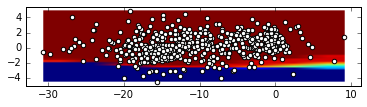

In [4]:
optim = CMA()
optim.call_cma()

('param', -6.5138311)
('param', 0.89921749)


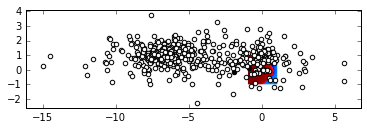

In [5]:
optim.final_draw()
